## Simulation using the SRT model


--- Final Results (SRT) ---
Average pressure drop: 0.02581
Average flow rate:     0.04050
Permeability (LB units): 0.313785
Porosity: 0.8896


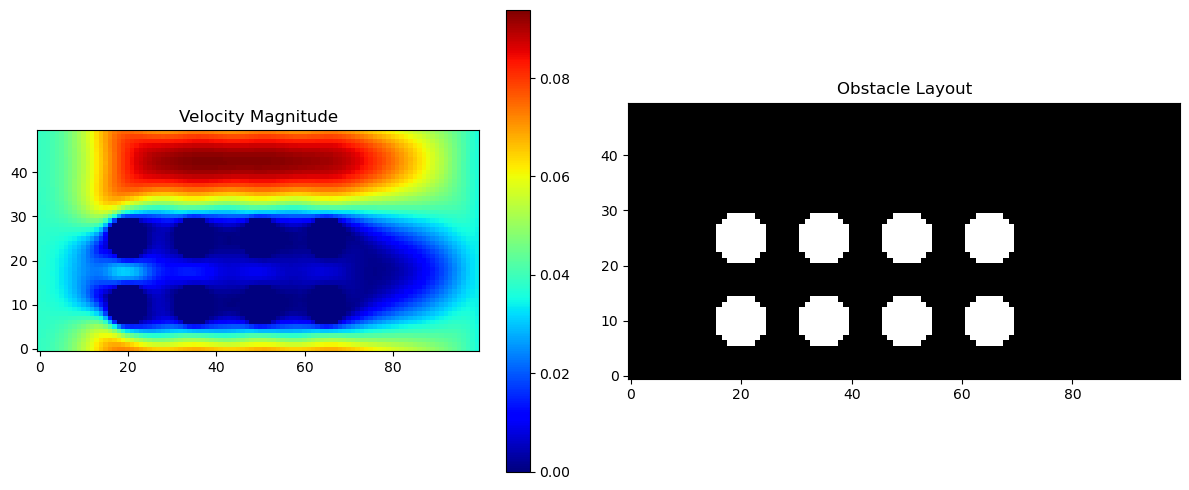

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------- Lattice & Fluid Parameters ------------------
nx, ny = 100, 50          # Domain size
nu = 0.1                  # Kinematic viscosity
tau = 3*nu + 0.5          # Relaxation time (SRT)
omega = 1.0 / tau         # Relaxation rate

# D2Q9 velocities, weights, and opposites
c = np.array([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1],
              [1, 1], [-1, 1], [-1, -1], [1, -1]])
w = np.array([4/9] + [1/9]*4 + [1/36]*4)
opp = [0, 3, 4, 1, 2, 7, 8, 5, 6]

# ----------------- Fields Initialization ------------------
rho = np.ones((nx, ny))        # Density field
ux = np.zeros((nx, ny))        # x-velocity field
uy = np.zeros((nx, ny))        # y-velocity field

# Equilibrium distribution function
def equilibrium(rho, ux, uy):
    feq = np.zeros((9, nx, ny))
    for i, ci in enumerate(c):
        cu = 3 * (ci[0]*ux + ci[1]*uy)
        feq[i] = w[i] * rho * (1 + cu + 0.5*cu**2 - 1.5*(ux**2 + uy**2))
    return feq

# Initialize distributions
f = equilibrium(rho, ux, uy)

# ----------------- Define Porous Medium ------------------
solid = np.zeros((nx, ny), dtype=bool)
for i in range(20, 80, 15):
    for j in range(10, 40, 15):
        rr, cc = np.ogrid[:nx, :ny]
        mask = (rr - i)**2 + (cc - j)**2 < 5**2
        solid[mask] = True

# ----------------- Core LBM Steps ------------------
def bounce_back(f, solid):
    for i in range(9):
        f[i][solid] = f[opp[i]][solid]
    return f

def collision_srt(f, omega):
    rho = np.sum(f, axis=0)
    ux = np.sum(f * c[:,0].reshape(-1,1,1), axis=0) / rho
    uy = np.sum(f * c[:,1].reshape(-1,1,1), axis=0) / rho
    feq = equilibrium(rho, ux, uy)
    f = f + omega * (feq - f)
    return f, rho, ux, uy

def streaming(f):
    f_streamed = np.zeros_like(f)
    for i, ci in enumerate(c):
        f_streamed[i] = np.roll(np.roll(f[i], ci[0], axis=0), ci[1], axis=1)
    return f_streamed

def set_pressure_bc(f, rho_in, rho_out):
    # Inlet (left)
    ux_in = 0.05
    uy_in = 0.0
    rho_left = np.full((nx, ny), rho_in)
    ux_left = np.full((nx, ny), ux_in)
    uy_left = np.full((nx, ny), uy_in)
    feq_left = equilibrium(rho_left, ux_left, uy_left)
    for i in [1, 5, 8]:
        f[i, 0, :] = feq_left[i, 0, :]

    # Outlet (right)
    rho_right = np.full((nx, ny), rho_out)
    ux_right = np.zeros((nx, ny))
    uy_right = np.zeros((nx, ny))
    feq_right = equilibrium(rho_right, ux_right, uy_right)
    for i in [3, 6, 7]:
        f[i, -1, :] = feq_right[i, -1, :]

# ----------------- Simulation Loop ------------------
n_steps = 5000
flow_rates = []
pressure_drops = []

for step in range(n_steps):
    f, rho, ux, uy = collision_srt(f, omega)
    f = streaming(f)
    f = bounce_back(f, solid)
    set_pressure_bc(f, rho_in=1.1, rho_out=1.0)

    if step > n_steps // 2:
        dp = np.mean(rho[0, :]) - np.mean(rho[-1, :])
        q = np.mean(ux[~solid])
        pressure_drops.append(dp)
        flow_rates.append(q)

# ----------------- Postprocessing ------------------
avg_dp = np.mean(pressure_drops)
avg_q = np.mean(flow_rates)
mu = nu
L = nx
A = ny
K = mu * avg_q * L / (avg_dp * A)

# Output results
print("\n--- Final Results (SRT) ---")
print(f"Average pressure drop: {avg_dp:.5f}")
print(f"Average flow rate:     {avg_q:.5f}")
print(f"Permeability (LB units): {K:.6f}")
print(f"Porosity: {1 - np.sum(solid) / (nx * ny):.4f}")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Velocity Magnitude")
plt.imshow(np.sqrt(ux**2 + uy**2).T, origin='lower', cmap='jet')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Obstacle Layout")
plt.imshow(solid.T, origin='lower', cmap='gray')
plt.tight_layout()
plt.show()

## Validation of Darcy's law

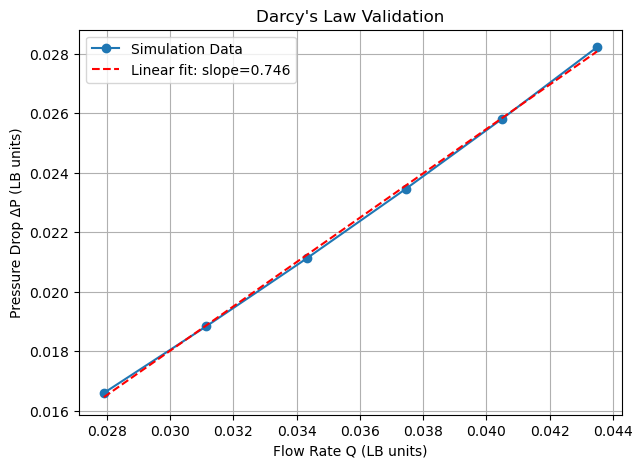

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define a list of inlet densities to test different pressure gradients
rho_in_list = np.linspace(1.02, 1.12, 6)  #  1.02, 1.04, ..., 1.12
rho_out = 1.0  # fixed outlet density

pressure_drops = []
flow_rates = []

for rho_in in rho_in_list:
    # Reset or reinitialize your simulation fields here (rho, ux, uy, f, etc.)
    # Make sure to reinitialize distributions f to equilibrium with rho=1, ux=0, uy=0
    # For example:
    rho = np.ones((nx, ny))
    ux = np.zeros((nx, ny))
    uy = np.zeros((nx, ny))
    f = equilibrium(rho, ux, uy)
    
    # Run the simulation for a fixed number of steps (or until steady state)
    for step in range(n_steps):
        f, rho, ux, uy = collision_srt(f, omega)
        f = streaming(f)
        f = bounce_back(f, solid)
        set_pressure_bc(f, rho_in=rho_in, rho_out=rho_out)
    
    # After simulation, compute average pressure drop and flow rate
    dp = np.mean(rho[0, :]) - np.mean(rho[-1, :])
    q = np.mean(ux[~solid])
    
    pressure_drops.append(dp)
    flow_rates.append(q)

# Convert to numpy arrays for plotting
pressure_drops = np.array(pressure_drops)
flow_rates = np.array(flow_rates)

# Plot pressure drop vs flow rate
plt.figure(figsize=(7,5))
plt.plot(flow_rates, pressure_drops, 'o-', label='Simulation Data')
plt.xlabel('Flow Rate Q (LB units)')
plt.ylabel('Pressure Drop ΔP (LB units)')
plt.title('Darcy\'s Law Validation')
plt.grid(True)

# Optionally, fit a linear line and plot
coeffs = np.polyfit(flow_rates, pressure_drops, 1)
plt.plot(flow_rates, np.polyval(coeffs, flow_rates), 'r--', label=f'Linear fit: slope={coeffs[0]:.3f}')
plt.legend()
plt.show()

## Simulation using the TRT model


--- Final Results ---
Average pressure drop: 0.02580
Average flow rate:     0.04050
Permeability (LB units): 0.313998
Porosity: 0.8896


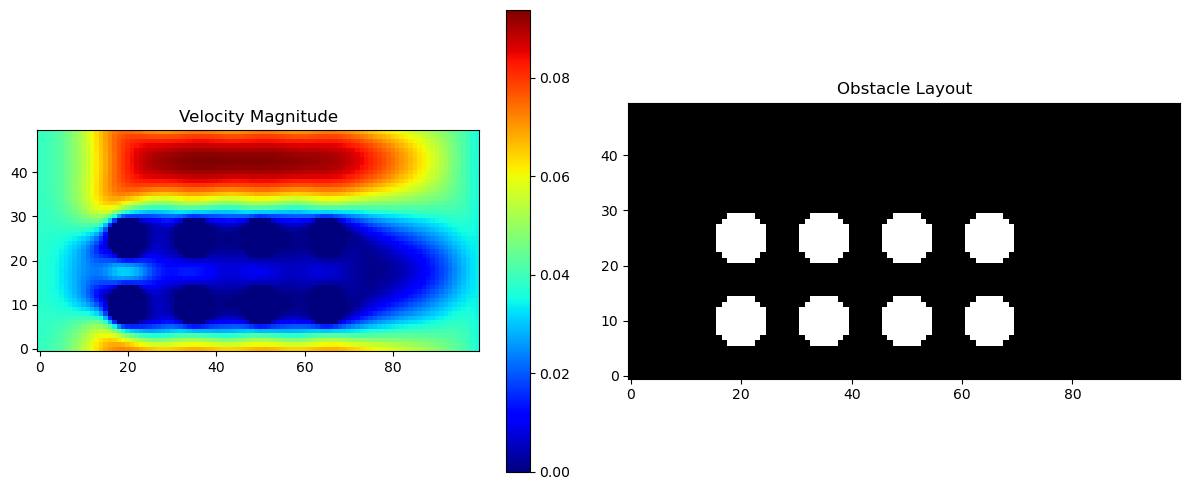

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Lattice parameters for D2Q9
nx, ny = 100, 50  # domain size
nu = 0.1          # kinematic viscosity
tau = 3*nu + 0.5  # relaxation time
omega_srt = 1.0 / tau
omega_trt_even = omega_srt
omega_trt_odd = 1.2  # TRT: separate odd relaxation rate

# Lattice velocities and weights
c = np.array([[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1],
              [1, 1], [-1, 1], [-1, -1], [1, -1]])
w = np.array([4/9] + [1/9]*4 + [1/36]*4)
opp = [0, 3, 4, 1, 2, 7, 8, 5, 6]

# Initialize fields
rho = np.ones((nx, ny))
ux = np.zeros((nx, ny))
uy = np.zeros((nx, ny))

# Initial distribution function
def equilibrium(rho, ux, uy):
    feq = np.zeros((9, nx, ny))
    for i, ci in enumerate(c):
        cu = 3 * (ci[0]*ux + ci[1]*uy)
        feq[i] = w[i] * rho * (1 + cu + 0.5*cu**2 - 1.5*(ux**2 + uy**2))
    return feq

f = equilibrium(rho, ux, uy)

# Porous medium: circular obstacles
solid = np.zeros((nx, ny), dtype=bool)
for i in range(20, 80, 15):
    for j in range(10, 40, 15):
        rr, cc = np.ogrid[:nx, :ny]
        mask = (rr - i)**2 + (cc - j)**2 < 5**2
        solid[mask] = True

def bounce_back(f, solid):
    for i in range(9):
        f[i][solid] = f[opp[i]][solid]
    return f

def collision_trt(f, omega_even, omega_odd):
    rho = np.sum(f, axis=0)
    ux = np.sum(f * c[:,0].reshape(-1,1,1), axis=0) / rho
    uy = np.sum(f * c[:,1].reshape(-1,1,1), axis=0) / rho
    feq = equilibrium(rho, ux, uy)

    f_plus = 0.5 * (f + f[opp])
    f_minus = 0.5 * (f - f[opp])
    feq_plus = 0.5 * (feq + feq[opp])
    feq_minus = 0.5 * (feq - feq[opp])

    f = f - omega_even * (f_plus - feq_plus) - omega_odd * (f_minus - feq_minus)
    return f, rho, ux, uy

def streaming(f):
    f_streamed = np.zeros_like(f)
    for i, ci in enumerate(c):
        f_streamed[i] = np.roll(np.roll(f[i], ci[0], axis=0), ci[1], axis=1)
    return f_streamed

def set_pressure_bc(f, rho_in, rho_out):
    # Inlet (left boundary)
    ux_in = 0.05
    uy_in = 0.0
    rho_left = np.full((nx, ny), rho_in)
    ux_left = np.full((nx, ny), ux_in)
    uy_left = np.full((nx, ny), uy_in)
    feq_left = equilibrium(rho_left, ux_left, uy_left)
    for i in [1, 5, 8]:
        f[i, 0, :] = feq_left[i, 0, :]

    # Outlet (right boundary)
    rho_right = np.full((nx, ny), rho_out)
    ux_right = np.zeros((nx, ny))
    uy_right = np.zeros((nx, ny))
    feq_right = equilibrium(rho_right, ux_right, uy_right)
    for i in [3, 6, 7]:
        f[i, -1, :] = feq_right[i, -1, :]

# Main loop
n_steps = 5000
flow_rates = []
pressure_drops = []

for step in range(n_steps):
    f, rho, ux, uy = collision_trt(f, omega_trt_even, omega_trt_odd)
    f = streaming(f)
    f = bounce_back(f, solid)
    set_pressure_bc(f, rho_in=1.1, rho_out=1.0)

    if step > n_steps // 2:
        # Monitor flow and pressure
        dp = np.mean(rho[0, :]) - np.mean(rho[-1, :])
        q = np.mean(ux[~solid])  # average fluid velocity
        flow_rates.append(q)
        pressure_drops.append(dp)

# Final results
avg_q = np.mean(flow_rates)
avg_dp = np.mean(pressure_drops)
mu = nu  # Dynamic viscosity (LB units)
L = nx
A = ny
K = mu * avg_q * L / (avg_dp * A)

# Output
print("\n--- Final Results ---")
print(f"Average pressure drop: {avg_dp:.5f}")
print(f"Average flow rate:     {avg_q:.5f}")
print(f"Permeability (LB units): {K:.6f}")
print(f"Porosity: {1 - np.sum(solid) / (nx * ny):.4f}")

# Optional plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Velocity Magnitude")
plt.imshow(np.sqrt(ux**2 + uy**2).T, origin='lower', cmap='jet')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Obstacle Layout")
plt.imshow(solid.T, origin='lower', cmap='gray')
plt.tight_layout()
plt.show()
